### Optimizing Rumor Detection: A Dual Feature Extraction Approach with LIME-Based Model Explanation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords, wordnet
# from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold



from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import joblib

In [2]:
# dataset link = https://www.kaggle.com/c/fake-news/data

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.shape

(20800, 5)

In [6]:
df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

1 ==> unreliable / rumor

0 ==> reliable / non-rumor

Balanced Class Labels

In [7]:
df = df.drop(['id', 'author', 'title'], axis = 1)
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


### Null value

In [9]:
df.isnull().sum()

text     39
label     0
dtype: int64

In [10]:
# The forwardfill() method is used to fill in missing values 
# in a DataFrame or Series with the previous valid observation

df['text'].fillna(method='ffill', inplace=True)

In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Duplicate value

In [12]:
df.duplicated().value_counts()

False    20409
True       391
dtype: int64

In [13]:
# dropping Duplicates

df = df.drop_duplicates(keep='first')

In [14]:
df.duplicated().value_counts()

False    20409
dtype: int64

In [15]:
df.shape

(20409, 2)

## Preprocessing

### Data Cleaning

In [16]:
# Ensure you have the necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constants for cleaning
PUNCT_TO_REMOVE = string.punctuation + '“”'
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
# Combine all cleaning functions
def clean_text(text, FREQWORDS=None, RAREWORDS=None):
    if isinstance(text, str):
        # 1. Convert to lowercase
        text = text.lower()
        
        # 2. Remove punctuation
        text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # 3. Remove hyperlinks, markup, numbers, and special symbols
        text = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', text)
        text = re.sub('&gt;', "", text)  # Greater than sign
        text = re.sub('&#x27;', "'", text)  # Apostrophe
        text = re.sub('&quot;', '"', text)
        text = re.sub('&#x2F;', ' ', text)
        text = re.sub('<p>', ' ', text)  # Paragraph tag
        text = re.sub('<i>', ' ', text)  # Italics tag
        text = re.sub('</i>', '', text)
        text = re.sub('&#62;', '', text)
        text = re.sub("\n", '', text)  # Newline
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r"[’']", "", text)  # Remove special apostrophes

        # 4. Remove stopwords
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        
        # 5. Remove frequent words if provided
        if FREQWORDS:
            text = " ".join([word for word in text.split() if word not in FREQWORDS])
        
        # 6. Remove rare words if provided
        if RAREWORDS:
            text = " ".join([word for word in text.split() if word not in RAREWORDS])
        
        # 7. Lemmatization
        pos_tagged_text = nltk.pos_tag(text.split())
        text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
        
        # 8. Remove URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)
        
    return text

In [18]:
# Apply the cleaning function on the dataset
def preprocess_df(df):
    # Remove URLs, Punctuation, Lowercase, etc. in one go
    df["text"] = df["text"].apply(lambda text: clean_text(text))

    # Get frequent words and remove them
    cnt = Counter()
    for text in df["text"].values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    
    # Get rare words and remove them
    rare_word_count = pd.Series(' '.join(df['text']).split()).value_counts()[-2:]
    RAREWORDS = list(rare_word_count.index)
    
    # Apply removal of frequent and rare words
    df["text"] = df["text"].apply(lambda text: clean_text(text, FREQWORDS=FREQWORDS, RAREWORDS=RAREWORDS))

    return df

In [19]:
# Use the function to clean and preprocess the dataframe
df = preprocess_df(df)
df.head()

,text,label
0,house dem aide didnt even see comeys letter ja...,1
1,ever get feeling life circle roundabout rather...,0
2,truth might get fired october tension intellig...,1
3,video civilian kill single u airstrike identif...,1
4,print iranian woman sentence six prison iran r...,1


## Split Data

In [20]:
X = df['text']  # Features
y = df['label'] # Target

In [21]:
print(X[:1])

0    house dem aide didnt even see comeys letter ja...
Name: text, dtype: object


In [22]:
print(y)

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20409, dtype: int64


### Feature Extraction

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Custom parameters for CountVectorizer
# count_vect = CountVectorizer(max_features=10000, ngram_range=(1, 2))

# Custom parameters for TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [24]:
# Apply CountVectorizer
# X_count = count_vect.fit_transform(X)


# Apply TfidfVectorizer
X_tfidf = tfidf_vect.fit_transform(X)

In [25]:
# Example of correct data splitting
# X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=42)
# X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [26]:
# print(f"X_train_count shape: {X_train_count.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test_count shape: {X_test_count.shape}")
# print(f"y_test shape: {y_test.shape}")

# print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
# print(f"y_train shape: {y_test.shape}")

## Model Training - TFIDF

### 1. Logistic Regression

In [27]:
# Initialize Logistic Regression model
log_reg_tf = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0, penalty='l2')

# Initialize k-fold cross-validation

kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    log_reg_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = log_reg_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9390
Mean F1 Score: 0.9378
Mean Precision: 0.9405
Mean Recall: 0.9350

=== Final Summed Confusion Matrix Across All Folds ===
[[9794  593]
 [ 651 9371]]


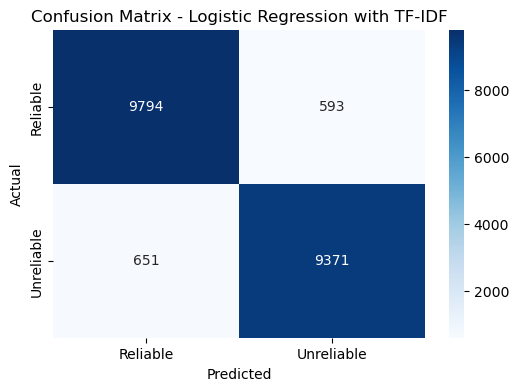

In [28]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression with TF-IDF')
plt.show()

In [29]:
# Save the trained model to a file

# joblib.dump(log_reg_tf, 'logistic_regression_model_tfidf.pkl')

### 2. Naive Bayes

In [30]:
# Initialize the Naive Bayes model
naive_bayes_tf = MultinomialNB(alpha=1.0, fit_prior=True)

# Initialize k-fold cross-validation

kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    naive_bayes_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = naive_bayes_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.8921
Mean F1 Score: 0.8854
Mean Precision: 0.9247
Mean Recall: 0.8494

=== Final Summed Confusion Matrix Across All Folds ===
[[9693  694]
 [1509 8513]]


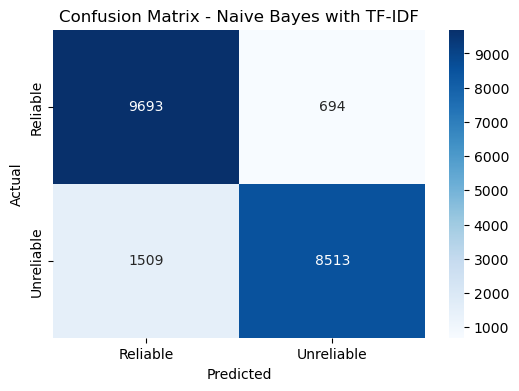

In [31]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes with TF-IDF')
plt.show()

In [32]:
# Save the trained model to a file

# joblib.dump(naive_bayes_tf, 'naive_bayes_model_tfidf.pkl')

### 3. Stochastic Gradient Descent (SGD)

In [57]:
# Initialize the Stochastic Gradient Descent (SGD) Classifier
sgd_tf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, tol=1e-3, random_state=42)

# Initialize k-fold cross-validation

kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    sgd_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = sgd_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9347
Mean F1 Score: 0.9332
Mean Precision: 0.9380
Mean Recall: 0.9285

=== Final Summed Confusion Matrix Across All Folds ===
[[9772  615]
 [ 717 9305]]


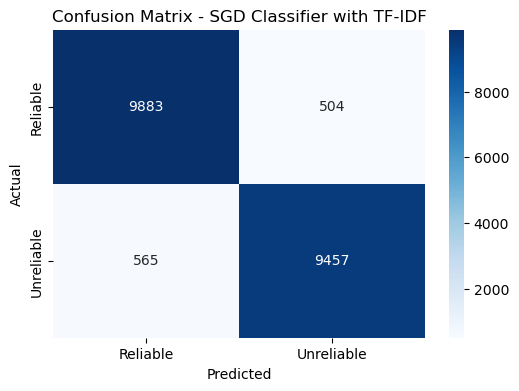

In [34]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SGD Classifier with TF-IDF')
plt.show()

In [52]:
# Save the trained model to a file

joblib.dump(sgd_tf, 'stochastic_gradient_descent_model_tfidf.pkl')

['stochastic_gradient_descent_model_tfidf.pkl']

### 4. K-Nearest Neighbors (KNN)

In [36]:
# Initialize the KNN model
knn_tf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # p=2 means Euclidean distance


# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    knn_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.5767
Mean F1 Score: 0.6956
Mean Precision: 0.5376
Mean Recall: 0.9849

=== Final Summed Confusion Matrix Across All Folds ===
[[1898 8489]
 [ 151 9871]]


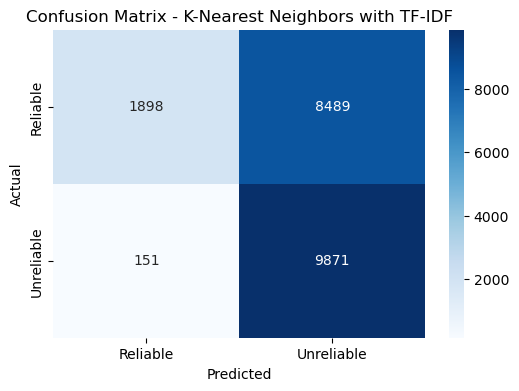

In [37]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - K-Nearest Neighbors with TF-IDF')
plt.show()

In [38]:
# Save the trained model to a file

# joblib.dump(knn_tf, 'k-nearest_neighbors_model_tfidf.pkl')

### 5. Decision Tree

In [39]:
# Initialize the Decision Tree model
decision_tree_tf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=42)


# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    decision_tree_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = decision_tree_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.8362
Mean F1 Score: 0.8338
Mean Precision: 0.8306
Mean Recall: 0.8371

=== Final Summed Confusion Matrix Across All Folds ===
[[8676 1711]
 [1633 8389]]


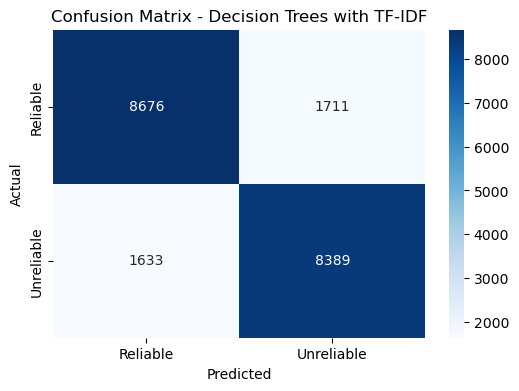

In [40]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Trees with TF-IDF')
plt.show()

In [41]:
# Save the trained model to a file

# joblib.dump(decision_tree_tf, 'decision_tree_model_tfidf.pkl')

### 6. Random Forest

In [42]:
# Initialize the Random Forest model
random_forest_tf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42, n_jobs=-1)


# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    random_forest_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = random_forest_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9228
Mean F1 Score: 0.9195
Mean Precision: 0.9424
Mean Recall: 0.8977

=== Final Summed Confusion Matrix Across All Folds ===
[[9837  550]
 [1025 8997]]


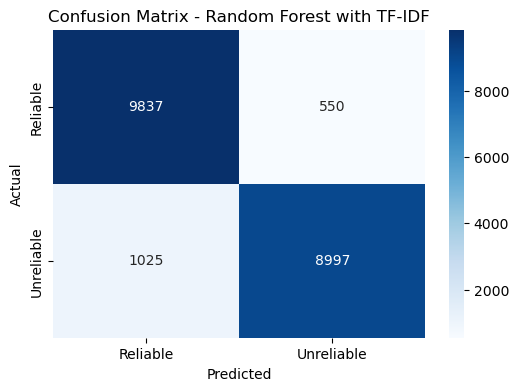

In [43]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest with TF-IDF')
plt.show()

In [44]:
# Save the trained model to a file

# joblib.dump(random_forest_tf, 'random_forest_model_tfidf.pkl')

### 7. Support Vector Machine (SVM)

In [54]:
# Initialize the Support Vector Machine model with a linear kernel
svm_model_tf = SVC(kernel='linear', C=1.0, random_state=42, probability=True)


# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    svm_model_tf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = svm_model_tf.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9476
Mean F1 Score: 0.9465
Mean Precision: 0.9491
Mean Recall: 0.9440

=== Final Summed Confusion Matrix Across All Folds ===
[[9879  508]
 [ 561 9461]]


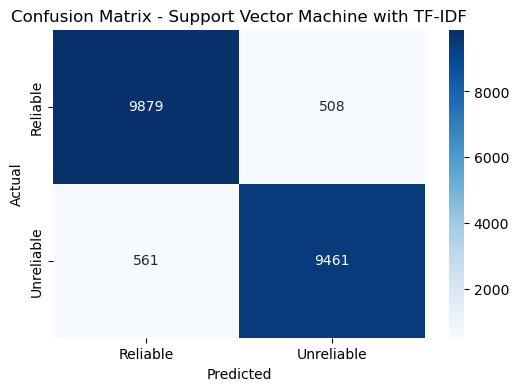

In [55]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Support Vector Machine with TF-IDF')
plt.show()

In [56]:
# Save the trained model to a file

joblib.dump(svm_model_tf, 'svm_model_tfidf.pkl')

['svm_model_tfidf.pkl']